# Integrated Gradients: An interpretation method for deep learning models

Here is a brief overview of Integrated Gradients, a method we use to interpret our CNN model predictions. The main motivation behind Integrated Gradients is that when we use a vanilla gradient method to attribute feature importance, we run into the problem of *saturation*. If the function has plateaued, the gradients will be close to zero, however the feature may still be important. Integrated Gradients solves this problem by considering the path from a baseline input (e.g. all zeros) to the actual input, and integrating the gradients along this path. This way, we capture the total change in the output as we move from the baseline to the actual input, providing a more accurate attribution of feature importance. Another problem that vanilla gradient methods face is that they can be highly sensitive to noise: a small perturbation in the input can lead to large changes in the gradient, making the attributions unstable. Since Integrated Gradients considers the entire path from the baseline to the input, it averages out these small perturbations, leading to more stable and reliable attributions.

## Integrated Gradients Method (Sundararajan et al., 2017)

Given a model $ F: \mathbb{R}^n \to [0, 1] $ and an input $x \in \mathbb{R}^n $, the Integrated Gradients for the $i^{th} $ feature is defined as:

$$IG_i(x) = (x_i - x'_i) \times \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} d\alpha$$

where $ x' $ is the baseline input (e.g., all zeros), and $ \alpha $ is a scaling factor that varies from 0 to 1. 

In practice this integral is approximated using a Riemann sum:

$$IG_i(x) \approx (x_i - x'_i) \times \frac{1}{m} \sum_{k=1}^{m} \frac{\partial F(x' + \frac{k}{m} \times (x - x'))}{\partial x_i}$$

where $ m $ is the number of steps in the approximation. A larger $ m $ leads to a more accurate approximation of the integral. Generally $m$ is chosen between 20 and 300, in our case we use $m=50$ due to computational constraints.

### Properties of Integrated Gradients

In the original paper by Sundararajan et al. (2017), the authors prove that Integrated Gradients satisfy two important properties:

1. **Sensitivity**: If the input differs from the baseline in only one feature and the model's output changes, then the attribution for that feature should be non-zero. This ensures that important features are correctly identified.

2. **Implementation Invariance**: If two models are functionally equivalent (i.e., they produce the same output for all inputs), then their attributions should also be identical. This property ensures that the attribution method is robust to different implementations of the same function.

Intuitively, Integrated Gradients can be thought of as walking from the baseline input to the full input, and accumulating the gradients along the way. This captures the total contribution of each feature to the change in the model's output, providing a more comprehensive and reliable attribution compared to vanilla gradient methods, whilst avoiding saturation and noise issues.

## SG - IG: SmoothGrad Integrated Gradients 

One way we can try to improve the stability of Integrated Gradients is to combine it with SmoothGrad, resulting in the SmoothGrad Integrated Gradients (SG-IG) method. The idea behind SG-IG is to smooth the function first using SmoothGrad, and them apply Integrated Gradients to the smoothed function. This helps to reduce noise and improve the stability of the attributions.

If we define SmoothGrad as:

$$SG(x) = \frac{1}{N} \sum_{i=1}^{N} \nabla F(x + \epsilon_i))$$

where $ N $ is the number of noisy samples, and $\epsilon_i \sim \mathcal{N}(0, \sigma^2) $ is Gaussian noise with mean 0 and variance $ \sigma^2 $, then the SG-IG for the $ i^{th} $ feature is defined as:

$$SG\text{-}IG_i(x) = \frac{1}{N} \sum_{j=1}^{N} IG_i(x + \epsilon_j)$$

where $ IG_i(x + \epsilon_j) $ is the Integrated Gradients for the noisy input $ x + \epsilon_j $.



## Explainer Plots

In the first plot, the blue line represents an example gradient function, and the grey bars represent the Riemann sum contributions at each step. Clearly, in practice the gradient function is much higher dimensional, and the baseline will not just be the x-axis, but this plot can still give a good intuition of how Integrated Gradients works.

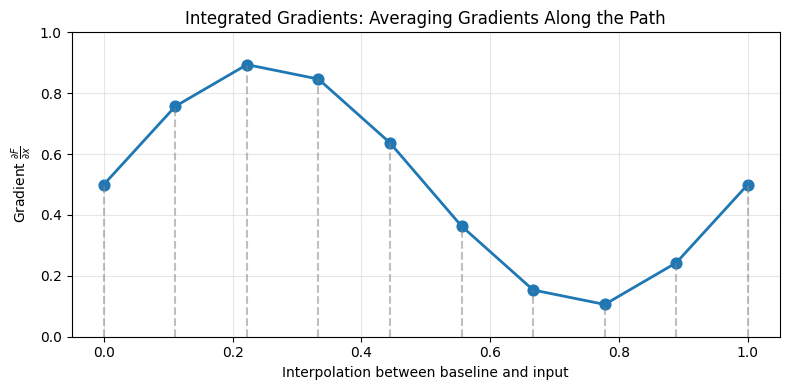

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# α values (interpolation steps)
m = 10
alphas = np.linspace(0, 1, m)

# A synthetic gradient function (just for illustration)
grad = 0.5 + 0.4*np.sin(2*np.pi*alphas)  # pretend this is dF/dx at each α

# Plot
plt.figure(figsize=(8,4))

# Continuous curve
plt.plot(alphas, grad, linewidth=2)
plt.scatter(alphas, grad, s=60)

# Vertical bars (Riemann sum visualisation)
for a, g in zip(alphas, grad):
    plt.vlines(a, 0, g, colors='gray', linestyles='dashed', alpha=0.5)

plt.xlabel(r'Interpolation between baseline and input')
plt.ylabel(r'Gradient $\frac{\partial F}{\partial x}$')
plt.title('Integrated Gradients: Averaging Gradients Along the Path')

plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


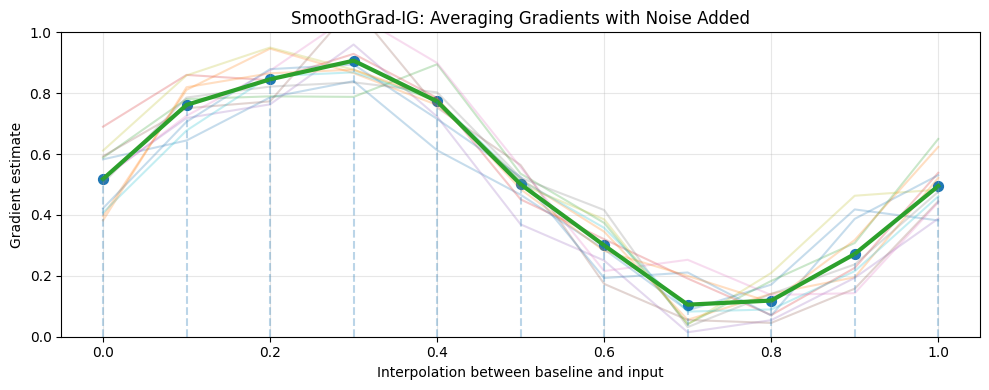

In [4]:

# α values (interpolation steps)
m = 11
alphas = np.linspace(0, 1, m)

# Base gradient curve (same style as IG figure)
base_grad = 0.5 + 0.4*np.sin(2*np.pi*alphas)

# Generate noisy gradients for SmoothGrad-IG
n_samples = 12                      # number of noisy draws
noise_level = 0.08                 # std of noise added

noisy_grads = [
    base_grad + np.random.normal(0, noise_level, size=base_grad.shape)
    for _ in range(n_samples)
]

# SmoothGrad-IG = average across noisy samples
smoothgrad = np.mean(noisy_grads, axis=0)

# --- Plot ---
plt.figure(figsize=(10, 4))

# Plot noisy samples (faint, multi-colored)
for g in noisy_grads:
    plt.plot(alphas, g, alpha=0.25)

# SmoothGrad-IG average line (bold)
plt.plot(alphas, smoothgrad, linewidth=3)
plt.scatter(alphas, smoothgrad, s=50)

# Vertical dashed lines showing Riemann sum points
for a, g in zip(alphas, smoothgrad):
    plt.vlines(a, 0, g, linestyles='dashed', alpha=0.3)

plt.xlabel(r'Interpolation between baseline and input')
plt.ylabel('Gradient estimate')
plt.title('SmoothGrad-IG: Averaging Gradients with Noise Added')

plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## References

[1] Sundararajan, M., Taly, A., & Yan, Q. (2017). Axiomatic attribution for deep networks. In Proceedings of the 34th International Conference on Machine Learning-Volume 70 (pp. 3319-3328). JMLR. org.
\\
[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F., & Wattenberg, M. (2017). Smoothgrad: removing noise by adding noise. arXiv preprint arXiv:1706.03825.